In [ ]:
!pip3 install pysam

In [102]:
import pysam
%matplotlib inline
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

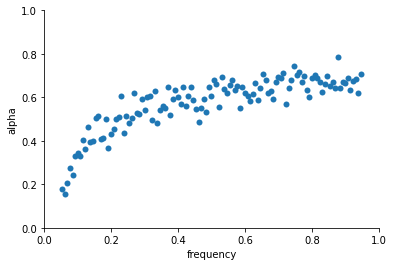

In [202]:
## Check sample data from Haller & Messer 2017 (https://github.com/MesserLab/asymptoticMK/tree/master)
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/Extensions_MKT/'
file_name = 'sample_polymorphism_levels.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t') 
d = 500
d0 = 1000
df['alpha'] = 1 - d0 / d * df['pN'] / df['pS']

# sns.scatterplot(data=df, x='x', y='pN', linewidth=0)
# sns.scatterplot(data=df, x='x', y='pS', linewidth=0)
sns.scatterplot(data=df, x='x', y='alpha', linewidth=0)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('frequency')
plt.ylabel('alpha')
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)


[31  9 12  5  1]
[0.016  0.1516 0.2872 0.4228 0.5584 0.694 ]
[66 22 11 23 11]
[0.016  0.1096 0.2032 0.2968 0.3904 0.484 ]


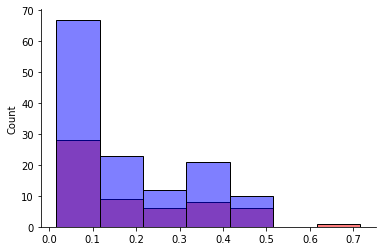

In [143]:
pN = '0.017,0.048,0.016,0.016,0.016,0.435,0.113,0.032,0.403,0.016,0.5,0.645,0.016,0.016,0.032,0.016,0.065,0.081,0.016,0.435,0.048,0.097,0.355,0.016,0.613,0.613,0.017,0.016,0.016,0.032'
pS = '0.177,0.016,0.081,0.145,0.145,0.016,0.968,0.016,0.032,0.016,0.065,0.016,0.016,0.129,0.016,0.081,0.016,0.081,0.016,0.161'

pN = '0.016,0.016,0.371,0.032,0.129,0.016,0.113,0.183,0.354,0.032,0.032,0.339,0.323,0.355,0.367,0.383,0.35,0.31,0.31,0.259,0.233,0.468,0.484,0.484,0.484,0.016,0.048,0.29,0.419,0.435,0.13,0.121,0.016,0.065,0.065,0.065,0.065,0.065,0.016,0.016,0.016,0.016,0.258,0.194,0.016,0.033,0.033,0.097,0.113,0.032,0.097,0.1,0.19,0.19,0.19,0.167,0.016,0.694'
pS = '0.452,0.452,0.452,0.145,0.129,0.113,0.129,0.145,0.145,0.032,0.016,0.016,0.048,0.065,0.097,0.177,0.183,0.2,0.194,0.048,0.333,0.333,0.259,0.21,0.35,0.339,0.339,0.355,0.355,0.35,0.35,0.35,0.069,0.283,0.484,0.484,0.468,0.468,0.032,0.452,0.355,0.355,0.355,0.355,0.355,0.129,0.35,0.323,0.226,0.032,0.032,0.032,0.048,0.048,0.29,0.29,0.403,0.435,0.435,0.107,0.103,0.083,0.083,0.083,0.033,0.065,0.065,0.065,0.065,0.065,0.032,0.032,0.032,0.016,0.016,0.016,0.226,0.306,0.306,0.306,0.048,0.21,0.258,0.258,0.258,0.194,0.161,0.161,0.05,0.033,0.033,0.033,0.097,0.097,0.097,0.339,0.339,0.339,0.016,0.032,0.032,0.032,0.032,0.032,0.032,0.048,0.097,0.097,0.097,0.097,0.097,0.097,0.097,0.097,0.103,0.1,0.083,0.05,0.034,0.034,0.19,0.19,0.19,0.19,0.167,0.167,0.167,0.15,0.032,0.016,0.016,0.016,0.016'

pN_list = [float(i) for i in pN.split(',')]
pS_list = [float(i) for i in pS.split(',')]

# W = 1 / len(l) * 5
hist_pN, bin_edges_pN = np.histogram(pN_list, bins=5)
hist_pS, bin_edges_pS = np.histogram(pS_list, bins=5)
print(hist_pN)
print(bin_edges_pN)
print(hist_pS)
print(bin_edges_pS)

sns.histplot(pN_list, binwidth=0.1, color='red', alpha=0.5)
sns.histplot(pS_list, binwidth=0.1, color='blue', alpha=0.5)
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

In [23]:
def split_into_bins(l, bins):
    
    ## Takes a list and puts it into bins
    data = np.array(l)
    digitized = np.digitize(data, bins)
    bin_counts = [digitized.tolist().count(i) for i in range(1, len(bins))]
    return bin_counts

In [44]:
def make_sfs(pN_list, pS_list, min_x=0.03, max_x=0.9, nbin=8):
    
    ## Takes two lists of pN and pS and converts them to a SFS dict:
    ## frequency: (pN count, pS count)
    bins = np.linspace(min_x, max_x, nbin)
    pN_bins = split_into_bins(pN_list, bins)
    pS_bins = split_into_bins(pS_list, bins)

    freq_dict = {}
    i = 0
    # represent each frequency with its upper bound
    for freq in bins[1:]:
        if (pS_bins[i] != 0) and (pN_bins[i] != 0):
            freq_dict[round(freq, 3)] = (pN_bins[i], pS_bins[i])
        i += 1
    return freq_dict

In [45]:
def claculate_alpha_x(d, d0, freq_dict):

    ## Calcualtes alpha based on dN,dS and SFS of pN/pS from freq_dict
    f = list(freq_dict.keys())
    p = [freq_dict[f][0] for f in freq_dict]
    p0 = [freq_dict[f][1] for f in freq_dict]
    
    alpha = []
    for x in freq_dict:
        p_x = freq_dict[x][0]
        p0_x = freq_dict[x][1]
        alpha_x = 1 - d0 / d * p_x / p0_x
        alpha.append(alpha_x)
    return alpha

In [41]:
def linear_fit_alpha(alpha, freq_dict):

    ## Fits linear model: alpha = f(frequency) => computes asymtotic alpha -> (x=1)
    f = list(freq_dict.keys())
    model = LinearRegression().fit(np.array(f).reshape(-1, 1), np.array(alpha))
    # R^2
    rr = model.score(np.array(f).reshape(-1, 1), np.array(alpha))
    # k - slope, b - intercept
    k, b = float(model.coef_), float(model.intercept_)
    
    # plot data and the fit
#     plt.scatter(f, alpha)
#     plt.plot(f, [x * k + b for x in f], '--', color='red')
#     plt.xlim(0, 1)
#     plt.ylim(-1, 1)
#     plt.xlabel('allele frequency')
#     plt.ylabel('alpha')
#     sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

    # extrapolate to x = 1
    asympt_alpha = 1 * k + b
    return asympt_alpha

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


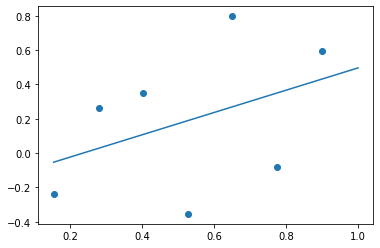

In [160]:
## alpha exponential fit
ln_alpha = np.log(alpha)
freqs = list(freq_dict.keys())

# list(freq_dict.keys())
model1 = np.polyfit(freqs, alpha, 1)
a1, b1 = model1[0], model1[1]

model2 = np.polyfit(freqs, ln_alpha, 1)
a2, b2 = model2[0], model2[1]


plt.scatter(freqs, alpha)
plt.plot(freqs + [1], a1*np.array(freqs + [1]) + b1)
plt.plot(freqs + [1], np.exp(b2) * np.exp(a2*np.array(freqs + [1])))

In [251]:
def exponential_fit(x, a, b, c):
    return a * np.exp(b * x) + c

def linear_fit(x, a, b):
    return a * x + b

In [254]:
# Haller & Messer 2017:  αfit(x) = -0.6*exp(−3.8x) + 0.6
x = df['x']
y = df['alpha']
# x = freqs
# y = alpha


R^2 exp: 0.8456119388000611; R^2 linear: 0.6592215733747169


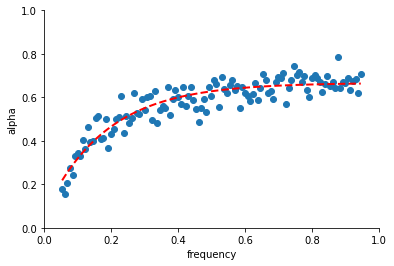

In [263]:
popt_exp, pcov_exp = curve_fit(exponential_fit, x, y, p0=[-1,-1,1], maxfev=5000)
y_exp_fit = exponential_fit(np.array(x), *popt_exp)

popt_lin, pcov_lin = curve_fit(linear_fit, x, y)
y_lin_fit = linear_fit(np.array(x), *popt_lin)

fig, axes = plt.subplots(figsize=(6, 4))
plt.scatter(x, y)
plt.plot(x, y_exp_fit, '--', linewidth=2, color='red')
# plt.plot(x, y_lin_fit)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('frequency')
plt.ylabel('alpha')
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

# Calculate R-squared
ss_total = np.sum((y - np.mean(y)) ** 2)
ss_residual_exp = np.sum((y - exponential_fit(np.array(x), *popt_exp)) ** 2)
ss_residual_lin = np.sum((y - linear_fit(np.array(x), *popt_lin)) ** 2)
rr_exp = 1 - (ss_residual_exp / ss_total)
rr_lin = 1 - (ss_residual_lin / ss_total)

print("R^2 exp: {}; R^2 linear: {}".format(rr_exp, rr_lin))


In [265]:
## Test get_af_from_vcf.py - exclude later!
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/Extensions_MKT/'
vcf_name = 'snpEff.polarized.passed.indInd.picPub.vcf.gz'
vcf_data = pysam.VariantFile(dir_path + vcf_name)

bed_line = 'CM051081 167553 167829'
contig = bed_line.split()[0]
start = int(bed_line.split()[1])
end = int(bed_line.split()[2])

AF_nonsyn = []
AF_syn = []
for i in vcf_data.fetch(contig, start, end):
    POS = i.pos
    REF = i.ref
    ALT = i.alts[0]
    AC = i.info['AC'][0]
    AN = i.info['AN']
    AA = i.info['AA']
    
    if AA != REF:
        # check if snp wasn't introduced with the outgroup
        if (AA == ALT) and (AC != 2):
            # flip AC
            AC = AN - AC
        # exlude if it is new or 3-way to resolve
        else:
            AC = 0
    # remove outgroup from AN
    AN = AN - 2
    AF = AC / AN
    
    if (AF != 0) and (AF != 1):
        if 'missense_variant' in i.info['ANN'][0]:
            AF_nonsyn.append(AF)
        elif 'synonymous_variant' in i.info['ANN'][0]:
            AF_syn.append(AF)
  

In [266]:
## Read your data per gene with syn/nonsyn AF
# dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
file_name = 'MK_test_indInd_ncbi/af.gene.longest.mk.tsv'
# file_data = glob(dir_path + file_name)[0]
# df = pd.read_csv(file_data, sep='\t')

## Read Degenotate table line by line and store in dict
mk_dict = {}
with open(file_name, 'r') as inf:
    for line in inf.readlines():
        # exclude header and lines with empty AF fields  
        if (not line.startswith('gene')) and (len(line.split()) == 11):
            gene = line.split()[0]
            mk_dict[gene] = {}
            mk_dict[gene]['t'] = line.split()[1]
            mk_dict[gene]['af_nonsyn'] = line.split()[2]
            mk_dict[gene]['af_syn'] = line.split()[3]
            mk_dict[gene]['dN'] = float(line.split()[6])
            mk_dict[gene]['dS'] = float(line.split()[7])
            mk_dict[gene]['pval'] = float(line.split()[8])
            ni = line.split()[9]
            if ni == 'NaN':
                    mk_dict[gene]['standard_alpha'] = ni
            else:
                mk_dict[gene]['standard_alpha'] = 1 - float(ni)
#             mk_dict[gene] = (t, af_nonsyn, af_syn, dN, dS, pval, standard_alpha)

383


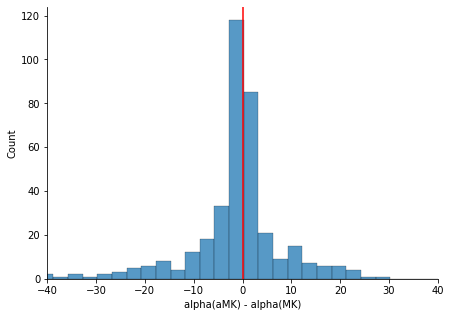

In [280]:
i = 0
delta_list = []

with open('aMKT.alpha.tsv', 'w') as ouf:
    for g in mk_dict:
        d = mk_dict[g]['dN']
        d0 = mk_dict[g]['dS']
        pN_list = [float(i) for i in mk_dict[g]['af_nonsyn'].split(',')]
        pS_list = [float(i) for i in mk_dict[g]['af_syn'].split(',')]
        standard_alpha = mk_dict[g]['standard_alpha']

        if (d > 0) and (standard_alpha != 'NaN'):
            freq_dict = make_sfs(pN_list, pS_list)
            alpha = claculate_alpha_x(d, d0, freq_dict)
            if len(alpha) > 1:
                asympt_alpha = linear_fit_alpha(alpha, freq_dict)
                ouf.write('{}\t{}\t{}\n'.format(g, asympt_alpha, 'asympt'))
        #       print('standard alpha: {}; asymptotic alpha: {}'.format(standard_alpha, asympt_alpha))
                delta_list.append(asympt_alpha - standard_alpha)
                i += 1
            else:
                asympt_alpha = standard_alpha
#                 ouf.write('{}\t{}\t{}\n'.format(g, asympt_alpha, 'standard'))
       #        print('standard alpha: {}; asymptotic alpha: {}'.format(standard_alpha, asympt_alpha))
        
print(i)

fig, axes = plt.subplots(figsize=(7, 5))
sns.histplot(delta_list, binwidth=3)
axes.axvline(x=0, color='red')
axes.set_xlim(-40, 40)

plt.xlabel('alpha(aMK) - alpha(MK)')
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

In [281]:
len(mk_dict)


11088

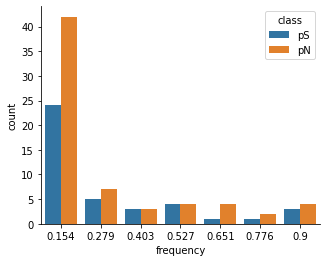

In [247]:
df_g = pd.DataFrame(zip(list(freq_dict.keys()) * 2,
                        [i[1] for i in freq_dict.values()] + [i[0] for i in freq_dict.values()],
                        ['pS']*len(freq_dict) + ['pN']*len(freq_dict)),
                    columns = ['freq', 'count', 'class'])

fig, axes = plt.subplots(figsize=(5, 4))
sns.barplot(data=df_g, x='freq', y='count', hue='class')
plt.xlabel('frequency')
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)


In [250]:
alpha

[-0.7190265486725664,
 -0.37522123893805315,
 0.017699115044247815,
 0.017699115044247815,
 -2.9292035398230087,
 -0.9646017699115044,
 -0.3097345132743363]